# Machine Adoption
## December, 2016
## Xiliang Lin

### 1. Setup Parallel Working Environment

Machine Specification

In [3]:
# machines = [("bushgcn14", 32), ("bushgcn15", 32),  ("bushgcn16", 32)]; # On Grid
machines = [("omar.gunty.org", 32)]

1-element Array{Tuple{String,Int64},1}:
 ("omar.gunty.org",32)

Add Remote Machine Workers

In [4]:
# addprocs(machines; tunnel=true)

In [ ]:
# Add procs on current host
addprocs(2)

Obtain the list of workers

In [6]:
np = workers()

2-element Array{Int64,1}:
 2
 3

In [7]:
remotecall_fetch(rand, 2, 20) # Test worker

20-element Array{Float64,1}:
 0.125315
 0.509012
 0.562488
 0.638643
 0.169471
 0.426414
 0.722267
 0.330293
 0.813497
 0.342184
 0.561411
 0.495001
 0.901421
 0.531968
 0.949653
 0.884172
 0.862619
 0.777075
 0.611741
 0.844824

Function similar to MPI broadcast

In [8]:
function broad_mpi(expr::Expr)
  for p in np
      @spawnat p eval(expr)
  end
end

broad_mpi (generic function with 1 method)

### 2. Settings and Load packages

In [9]:
#Set Directory
cd("/home/xlin0/Keurig");

#Load Packages
using Distributions, Optim, FastGaussQuadrature, Calculus

In [10]:
broad_mpi(:(using Distributions))

### 3. Solve the Value of Holding the Machine

Set parameters of dynamic problem

Assume the utility gain is governed by the following process
$\mu_t = \alpha_0 +\alpha_1\mu_{t-1}+\varepsilon_t$, and $\varepsilon_t \sim N(0, \sigma_0^2)$

In [11]:
β  = 0.995; # Discount factor
α0 = 0.009071309; 
α1 = 0.941864068;
σ0 = 0.07586;

Put discount factor to remote workers

In [12]:
broad_mpi(:(β=$β))

Obtain the grid of value function

In [13]:
@everywhere nodes = 20; # Degree of Chebyshev Zeros (nodes)
@everywhere order = 5; # Degree of Chebyshev Polynomials
@everywhere (a, b) = (0., 20.); # a need to be greater/equal to 1 for the function to be well behaved.
(cnode, cweight)=gausschebyshev(nodes); # Interpolation Nodes
tcnode = (cnode+1) * (b-a)/2 + a; # Transformed nodes

20-element Array{Float64,1}:
  0.0308267
  0.276301 
  0.761205 
  1.4736   
  2.39594  
  3.50552  
  4.77501  
  6.17317  
  7.66555  
  9.21541  
 10.7846   
 12.3345   
 13.8268   
 15.225    
 16.4945   
 17.6041   
 18.5264   
 19.2388   
 19.7237   
 19.9692   

Initialize W(ν)

In [14]:
W1 = zeros(Float64, nodes);
@everywhere T(i, x) = cos((i-1) .* acos(x));
Tmat = Float64[T(i,j) for i = 1:(order+1), j in cnode]; # Chebyshev Polynomial Matrix

6×20 Array{Float64,2}:
  1.0        1.0        1.0          …   1.0          1.0       1.0     
 -0.996917  -0.97237   -0.92388          0.92388      0.97237   0.996917
  0.987688   0.891007   0.707107         0.707107     0.891007  0.987688
 -0.97237   -0.760406  -0.382683         0.382683     0.760406  0.97237 
  0.951057   0.587785  -4.28626e-16     -1.60812e-16  0.587785  0.951057
 -0.92388   -0.382683   0.382683     …  -0.382683     0.382683  0.92388 

Chebyshev Approximation of Value Function

In [15]:
function capprox(w, x::Real)
    length(w) == nodes ? length(w) : error("function values not the same length as interpolation nodes")
    Wmat = repmat(w, 1, (order+1)); # Step 3 - function value at transformed node
    ccoef = diag(Tmat * Wmat) ./ sum(Tmat.^2,2)[:,1]; #Step 4 Compute coefficients
    if (a<=x<=b)
        return sum(Float64[T(i, 2 * (x-a)/(b-a) - 1) * ccoef[i] for i = 1:(order+1)]);
    elseif (x<a)
        abase = capprox(w, a)
        aslope = (capprox(w, a+0.0001) - abase)/0.0001
        return abase + aslope * (x-a) # Linear Extrapolation
    else
        bbase = capprox(w, b)
        bslope = (bbase - capprox(w, b - 0.0001))/0.0001
        return bbase + bslope * (x-b) # Linear Extrapolation
    end
end

capprox (generic function with 1 method)

Chebysheve Approximation of Value Function using Coefficients

In [16]:
@everywhere function coefun(ccoef, x::Real)
    if (a<=x<=b)
        return sum(Float64[T(i, 2. * (x-a)/(b-a) - 1.) * ccoef[i] for i = 1:(order+1)]);
    elseif (x<a)
        abase = coefun(ccoef, a)
        aslope = (coefun(ccoef, a+0.0001) - abase)/0.0001
        return abase + aslope * (x-a) # Linear Extrapolation
    else
        bbase = ccoef(ccoef, b)
        bslope = (bbase - coefun(ccoef, b - 0.0001))/0.0001
        return bbase + bslope * (x-b) # Linear Extrapolation
    end
end

Get Coefficient Function

In [17]:
function getcoef(w)
    Wmat = repmat(w, 1, (order+1)); # Step 3 - function value at transformed node
    ccoef = diag(Tmat * Wmat) ./ sum(Tmat.^2,2)[:,1]; #Step 4 Compute coefficients
    return ccoef
end

getcoef (generic function with 1 method)

Gauss Hermite Integration

In [18]:
(hermitenodes, hermitewts)=gausshermite(9);
function hermiteint(f::Function, μ::Float64, σ::Float64)
    return sqrt(1./pi) * sum(map(f, sqrt(2.)*σ*hermitenodes + μ) .* hermitewts);
end

hermiteint (generic function with 1 method)

Bellman - Value Function Iteration

In [19]:
function W1V(W)
    wappx(x::Real) = capprox(W, x);
    function wfun(ν::Real)
        return ν + β * hermiteint(wappx, α0+α1*ν, σ0)
    end
    return map(wfun, tcnode)
end

W1V (generic function with 1 method)

Solve the Bellman equation for valuation through value function iteration

In [20]:
tol = 1e-8
err = 1;
nx = 0;
while (err > tol)
    nx = nx+1;
    W1n = W1V(W1)
    err = sum(abs(W1n-W1))
    #println("Error is $(err), and interation is $(nx)")
    W1 = W1n
end

Obtain the coefficients for Chebyshev Coefficients

In [21]:
W1coef = getcoef(W1)
broad_mpi(:(W1coef = $W1coef))

### 4. Read Data and Put Data To Each Worker

In [40]:
hh_panel = readdlm("Data/Machine-Adoption/HW-MU-Panel.csv", ',', skipstart=1); # Household Machine Adoption Panel

2314429×17 Array{Any,2}:
  2000126  0        1    1  127.332  …  0  0.00281963  0  0  0  3  0  0   5
  2000126  0        2    2  127.332     0  0.00281963  0  0  0  2  0  0   5
  2000126  0        3    3  124.989     0  0.00296699  0  0  0  1  0  0   5
  2000126  0        4    4  127.332     0  0.00296699  0  0  0  0  0  0   5
  2000126  0        5    5  127.332     0  0.00296699  0  0  0  0  0  0   5
  2000126  0        6    6  127.332  …  0  0.00296699  0  0  0  0  0  0   6
  2000126  0        7    7  127.332     0  0.00296699  0  0  0  0  0  0   6
  2000126  0        8    8  127.332     0  0.00296699  0  0  0  0  0  0   6
  2000126  0        9    9  127.332     0  0.00296699  0  0  0  0  0  0   6
  2000126  0       10   10  127.332     0  0.00311435  0  0  0  0  0  0   6
  2000126  0       11   11  127.332  …  0  0.00311435  0  0  0  0  0  0   5
  2000126  0       12   12  121.317     0  0.00311435  0  0  0  0  0  0   5
  2000126  0       13   13  127.332     0  0.00311435  0  0  0 

Omit Observations with NA values

In [41]:
# NA list
None_NA_list=Array(Int64, 0)
for i in 1:size(hh_panel, 1)
  if (typeof(hh_panel[i,9]))<:Real
    push!(None_NA_list, i)
  end
end
hh_panel = hh_panel[None_NA_list, :];

Put data to each worker

In [42]:
(nr, nc) = size(hh_panel)
chunk_size = ceil(Int, nr/length(np))
@sync begin
    for p in np
        if p != np[end]
            r_expr = :(hh_panel = $(hh_panel[((p-2)*chunk_size+1):((p-1)*chunk_size), :]))
        else
            r_expr = :(hh_panel = $(hh_panel[((p-2)*chunk_size+1):end, :]))
        end
        @spawnat p eval(r_expr)
    end
end

Define Corresponding Vectors

In [43]:
@everywhere purch_vec = convert(Array{Int64}, hh_panel[:, 9])
@everywhere XMat = convert(Array{Float64}, hh_panel[:, [5, 6, 8]])
@everywhere ZMat = hh_panel[:, 10:15]
@everywhere ZMat = sparse(convert(Array{Float64}, hcat(ones(Float64, size(purch_vec)), ZMat)))
@everywhere pbar_n2 =  0.41564 * XMat[:,1] + 0.58436 * XMat[:,2];
@everywhere SMat = transpose(hcat(8.143757 + 0.938283*pbar_n2, pbar_n2, 0.0795693 + 0.9577252*XMat[:,3]))
@everywhere nobs = length(purch_vec)

Purge hh_adoption and other variables

In [44]:
@everywhere pbar_n2 = 0;
@sync broad_mpi(:(hh_adoption = 0));
@everywhere gc();

### 5. Value function when the household doesn't hold Keurig machine

Functions for Approximating the W Function

Kernal Density Function

W0 approximation

θ1 is the parameter vector

θ0 is the history of stored parameters

H is bandwidth matrix

wmat is the stored value functions

In [45]:
function WApprox(θ1::Vector, θ0::Matrix, H::Matrix, s1::Vector, s0::Matrix, h::Float64, wvec::Vector)
    cdist = MvNormal(θ1, H)
    wts0 = pdf(cdist, θ0)
    pbar_n2 = 0.41564*s1[1] + 0.58436*s1[2]
    pbar_n1 = 8.143757 + 0.938283*pbar_n2
    sbar_n = 0.0795693 + 0.9577252*s1[3]
    sdist = MvNormal([pbar_n1, pbar_n2, sbar_n], diagm([3.683^2, h, 0.6308^2]))
    wts1 = pdf(sdist, s0)
    wts = wts0 .* wts1
    wts[:] = wts ./ sum(wts)
    return (sum(wts .* wvec))
end

WApprox (generic function with 1 method)

Bellman Iteration -- Scaling Version 2 (Scaling the Type I Utility Shock)

In [46]:
function W0V(θ1::Vector, s1::Vector, w::Float64)
    return 100*log(exp(0.995*w/100) + exp((θ1[1] + θ1[2] * s1[1] + coefun(W1coef, s1[3]))/100))
end

W0V (generic function with 1 method)

W1 Vector

In [47]:
@everywhere function W1fun(n::Int64)
    W1vec = Array(Float64, n) 
    for i in 1:n
        W1vec[i] = coefun(W1coef, SMat[3, i])
    end
    return W1vec
end
@everywhere W1vec=W1fun(nobs)

Define function compute log-likelihood

In [81]:
# Compute the likelihood in each data. 
@everywhere function ll_fun!()
    snew = pdf(snew_dist, SMat)
    wts_old[:] = wts_old - tpdf[1] * spdf[:,1] + tnew * snew;
    ww_old[:] = ww_old - tpdf[1] * wtild[1] * spdf[:,1] + wnew * tnew * snew;
    
    spdf[:,:] = hcat(spdf[:, 2:end], snew);
    shift!(tpdf);
    push!(tpdf, tnew);
    shift!(wtild);
    push!(wtild, wnew);
    shift!(sdist)
    push!(sdist, snew_dist)

    tpdf1 =  pdf(tdist1, thtild);
    wts[:] = spdf * tpdf1;
    ww[:] = spdf * (tpdf1 .* wtild);

    Wa_old = ww_old./wts_old;
    Wa_new = ww./wts;
    
    ex_old0 = exp(0.995 * Wa_old/100)
    ex_new0 = exp(0.995 * Wa_new/100)
    
    ex_new1[:] = exp((theta1[1] + theta1[2] * XMat[:,1] + W1vec)/100)
    
    pval_0 = ex_old0/(ex_old0+ex_new0)
    pval_1 = ex_old1/(ex_old1+ex_new1)

    ll_0 = sum(log(pval_0).*purch_vec + log(1-pval_0).*(1-purch_vec))
    ll_1 = sum(log(pval_1).*purch_vec + log(1-pval_1).*(1-purch_vec))
    
    return hcat(ll0, ll1)
end

In [62]:
# Update only if accepted 
@everywhere function supdate!()
    tpdf[:] = tpdf1
    ex_old1[:] = ex_new1
    wts_old[:] = wts
    ww_old[:] = ww
end

Collect likelihood computed in each process and combine to create overall log-likelihood

In [63]:
val = rand(length(np), 2)
function ll!(f::Function, np::Array{Int64, 1})
    @sync begin
        for p in np
            @async val[p-1, :] = fetch(@spawnat p eval(:(ll_fun!())))
        end
    end
    return(sum(val,1))
end

ll! (generic function with 1 method)

### 6. Bayesian MCMC Setting and Draws

Function for Posterior Proportions

In [64]:
function postd(l1::Real, l0::Real, theta1::Vector, theta0::Vector, bhat::Vector, sigb::Matrix)
    return exp(l1 + log(pdf(MvNormal(bhat, sigb), theta1)) - l0 - log(pdf(MvNormal(bhat, sigb), theta0)))
end

postd (generic function with 1 method)

MCMC Settings

In [65]:
burnin = 0;
thin   = 1;
draws  = 2;
totdraws = draws*thin + burnin;
npar = 2;

Priors

In [66]:
bhat = zeros(Float64, npar)
sigb = eye(npar)*100

2×2 Array{Float64,2}:
 100.0    0.0
   0.0  100.0

Random Walk Setting

In [67]:
xm = hcat(ones(Float64, nr), convert(Array{Float64}, hh_panel[:, 5])/100)
sigs = round(inv(xm' * xm) * 10, 8)
walkdistr = MvNormal(zeros(npar), sigs);

Support of the state variables.

In [68]:
pd = Uniform(minimum(XMat[:,1]), maximum(XMat[:,1]))
pbard = Uniform(minimum(XMat[:,2]), maximum(XMat[:,2]))
mud = Uniform(minimum(XMat[:,3]), maximum(XMat[:,3]))

Distributions.Uniform{Float64}(a=0.0, b=8.74372106722585)

Approximation Bandwidth

In [69]:
h = 1.
H = 9*sigs

2×2 Array{Float64,2}:
  0.00289665  -0.00208656
 -0.00208656   0.00152406

Initialize storage for proposal parameters and corresponding W

In [70]:
@everywhere N_0 = 1000
thtild = [3.; -5.] .+ 10*rand(walkdistr, N_0);
stild = zeros(Float64, 3, N_0);
wtild = zeros(Float64, N_0);
for k in 1:300
    for i in 1:N_0
        thtild[:,i] = [3., -5.] + 10*rand(walkdistr)
        stild[:,i] = [rand(pd), rand(pbard), rand(mud)]
        wtild[i] = WApprox(thtild[:,i], thtild, H, stild[:,i], stild, h, wtild)
        wtild[i] = W0V(thtild[:,i], stild[:,i], wtild[i])
    end
    #println("Value is supposed to be $(wtild[i])")
end

Fetch data to remote workers

In [71]:
broad_mpi(:(thtild = $thtild));
broad_mpi(:(stild = $stild));
broad_mpi(:(wtild = $wtild));

Approximation Bandwidth

In [86]:
@everywhere h = 5;
broad_mpi(:(H = $sigs));

Starting Values of Parameters

In [73]:
@everywhere theta0 = [3.0, -5.]

Compute the pdfs of thetas

In [74]:
tdist0 = MvNormal(theta0, H);
tpdf =  pdf(tdist0, thtild);
broad_mpi(:(tpdf=$tpdf))

In [94]:
sH = diagm([10^2, 10^2, 0.6^2]);
sdist = Array(Distributions.MvNormal{Float64,PDMats.PDMat{Float64,Array{Float64,2}},Array{Float64,1}},0)
for i in 1:N_0
    push!(sdist, MvNormal(stild[:,i], sH))
end
@sync broad_mpi(:(sdist = $sdist))

Compute the pdfs of state for each household

In [95]:
@everywhere spdf = spzeros(nobs, N_0)
@everywhere function sden!()
    for i in 1:N_0
        spdf[:, N_0] = pdf(sdist[i], SMat)
    end
end

In [96]:
@everywhere sden!()

In [97]:
var(SMat, 2)

3×1 Array{Float64,2}:
 203.517    
 231.171    
   0.0602531

Compute old weights 

In [98]:
@everywhere wts_old  = spdf * tpdf;
@everywhere ww_old = spdf * (tpdf .* wtild);

Initialize storage of MCMC draws

In [99]:
thatd = zeros(Float64, draws, npar);

MCMC Draw Implementation

In [100]:
start_time = time_ns();
for d=1:totdraws
    # Proposed theta
    theta1 = theta0 + rand(walkdistr)
    broad_mpi(:(theta1 = $theta1))

    # Draw a state proposal
    s_i = [rand(pd), rand(pbard), rand(mud)]
    broad_mpi(:(s_i = $s_i))
    snew_dist = MvNormal(s_i, sH)
    broad_mpi(:(snew_dist = $snew_dist))

    # Push s_i to the new values
    push!(sdist, snew_dist)
    shift!(sdist)

    # Approximate the Value function
    w_i = WApprox(theta1, thtild, H, s_i, stild, h, wtild)

    # Bellman Iteration Once
    wnew = W0V(theta1, s_i, w_i)
    broad_mpi(:(wnew = $wnew))
    
    # Compute the pdfs
    tdist1 = MvNormal(theta1, H);
    broad_mpi(:(tdist1=$tdist1))
    
    # tnew pdf value
    tnew = pdf(tdist1, theta0);
    broad_mpi(:(tnew=$tnew))

    # Compute likelihood for the new
    llv = ll!(ll_new, np);
    println(llv)

    alpha = min(1, postd(llv[:,2], llv[:,1], theta1, theta0, bhat, sigb))
    if rand() <= alpha
        @sync broad_mpi(:(theta0 = $theta1))
        @sync broad_mpi(:(supdate!()))
    end

    # Store the posterior draws of mean betas and sigmas
    if ((d > burnin) && (d % thin == 0))
        indx = ceil(Int64, (d - burnin)/thin)
        thatd[indx, :] = theta0;
    end

    # Indicate the progress
    elapsed_t = time_ns() - start_time;
    println(theta0)
    @printf("%10.6f seconds has passed\n", elapsed_t/1e9)
    println("Finished drawing $(d) out of $(totdraws)")
end

LoadError: MethodError: no method matching WApprox(::Array{Float64,1}, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,2}, ::Int64, ::Array{Float64,1})[0m
Closest candidates are:
  WApprox(::Array{T,1}, ::Array{T,2}, ::Array{T,2}, ::Array{T,1}, ::Array{T,2}, [1m[31m::Float64[0m, ::Array{T,1}) at In[45]:2[0m

Save MCMC Draws

In [ ]:
writedlm("Data/Bayes-MCMC/Adoption-Coef.csv", thatd)

In [4]:
thatd = readdlm("/home/xlin0/Keurig/Data/Bayes-MCMC/Adoption-Coef-No-Control-2.csv")

20000×2 Array{Float64,2}:
 0.1       -0.1     
 0.1       -0.1     
 0.1       -0.1     
 0.1       -0.1     
 0.373685  -0.316998
 0.373685  -0.316998
 0.373685  -0.316998
 0.373685  -0.316998
 1.05945   -0.845751
 1.05945   -0.845751
 1.39419   -1.04395 
 1.39419   -1.04395 
 1.39419   -1.04395 
 ⋮                  
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 
 2.5008    -1.79666 

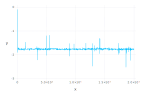

In [20]:
using Gadfly
plot(x=collect(1:20000), y=Vector(thatd[:,2]), Geom.line)